<a href="https://colab.research.google.com/github/LEEGWONSEOK/DataAnalysis-Project/blob/main/AI_04_%EC%9D%B4%EA%B6%8C%EC%84%9D_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade category_encoders
!pip install shap

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.7/dist-packages (2.2.2)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DataSet/laptop_price.csv', encoding='latin 1')

df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [ ]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


In [ ]:
'''
print(df['Company'].value_counts())
print()
print(df['TypeName'].value_counts())
print()
print(df['ScreenResolution'].value_counts())
print()
print(df['Cpu'].value_counts())
print()
print(df['Ram'].value_counts())
print()
print(df['Memory'].value_counts())
print()
print(df['OpSys'].value_counts())
print()
print(df['Price_euros'].value_counts())
'''

"\nprint(df['Company'].value_counts())\nprint()\nprint(df['TypeName'].value_counts())\nprint()\nprint(df['ScreenResolution'].value_counts())\nprint()\nprint(df['Cpu'].value_counts())\nprint()\nprint(df['Ram'].value_counts())\nprint()\nprint(df['Memory'].value_counts())\nprint()\nprint(df['OpSys'].value_counts())\nprint()\nprint(df['Price_euros'].value_counts())\n"

In [ ]:
## 데이터 전처리
import re

def df_cleaning(df):

  ## Replace 함수 생성
  def txt_prep(text):
    replacements = [
        ['Windows 10 S|Windows 7|Windows 10', 'Windows'],
        ['Mac OS X|macOS', 'Mac OS']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

  ## Price Euro -> Price KR
  df['Price_KR'] = round(df['Price_euros'] * 1340, 0).astype(int)
  df.drop('Price_euros', axis=1, inplace=True)
  
  ## PPI, X_res, Y_res
  df['ScreenResolution'] = df['ScreenResolution'].str.split(' ').str[-1]
  df['ScreenResolution'] = df['ScreenResolution'].str.replace('x',' ')
  df['X_res'] = (df['ScreenResolution'].str.split(' ').str[0]).astype(int)
  df['Y_res'] = (df['ScreenResolution'].str.split(' ').str[-1]).astype(int)
  df['ScreenResolution'] = df['X_res'].astype(int) * df['Y_res'].astype(int)
  df['PPI'] = round(((df['X_res'].astype(int))**2 + (df['Y_res'].astype(int))**2)**(1/2) / df['Inches'], 2) # PPI = (X해상도제곱 + Y해상도제곱)루트 / inch
  
  ## Column 제거
  df.drop('laptop_ID', axis=1, inplace=True)

  df['Memory'] = df['Memory'].astype(str).replace('\.0', '', regex=True)
  df["Memory"] = df["Memory"].str.replace('GB', '')
  df["Memory"] = df["Memory"].str.replace('TB', '000')
  new2 = df["Memory"].str.split("+", n = 1, expand = True)
  df["first"] = new2[0]
  df["first"] = df["first"].str.strip()
  df["second"]= new2[1]
  df["Layer1HDD"] = df["first"].apply(lambda x: 1 if "HDD" in x else 0)
  df["Layer1SSD"] = df["first"].apply(lambda x: 1 if "SSD" in x else 0)
  df["Layer1Hybrid"] = df["first"].apply(lambda x: 1 if "Hybrid" in x else 0)
  df["Layer1Flash_Storage"] = df["first"].apply(lambda x: 1 if "Flash Storage" in x else 0)
  df['first'] = df['first'].str.replace(r'\D', '')
  df["second"].fillna("0", inplace = True)
  df["Layer2HDD"] = df["second"].apply(lambda x: 1 if "HDD" in x else 0)
  df["Layer2SSD"] = df["second"].apply(lambda x: 1 if "SSD" in x else 0)
  df["Layer2Hybrid"] = df["second"].apply(lambda x: 1 if "Hybrid" in x else 0)
  df["Layer2Flash_Storage"] = df["second"].apply(lambda x: 1 if "Flash Storage" in x else 0)
  df['second'] = df['second'].str.replace(r'\D', '')
  df["first"] = df["first"].astype(int)
  df["second"] = df["second"].astype(int)
  df["Total_Memory"] = (df["first"]*(df["Layer1HDD"]+df["Layer1SSD"]+df["Layer1Hybrid"]+df["Layer1Flash_Storage"])+df["second"]*(df["Layer2HDD"]+df["Layer2SSD"]+df["Layer2Hybrid"]+df["Layer2Flash_Storage"]))
  df["Memory"] = df["Total_Memory"]
  df["HDD"] = (df["first"]*df["Layer1HDD"]+df["second"]*df["Layer2HDD"])
  df["SSD"] = (df["first"]*df["Layer1SSD"]+df["second"]*df["Layer2SSD"])
  df["Hybrid"] = (df["first"]*df["Layer1Hybrid"]+df["second"]*df["Layer2Hybrid"])
  df["Flash_Storage"] = (df["first"]*df["Layer1Flash_Storage"]+df["second"]*df["Layer2Flash_Storage"])
  
  df.drop(['first','second','Layer1HDD','Layer1SSD','Layer1Hybrid','Layer1Flash_Storage','Layer2HDD','Layer2SSD','Layer2Hybrid','Layer2Flash_Storage','Total_Memory'],axis=1,inplace=True)
  
  ## 형변환
  df['Ram'] = df['Ram'].str.replace('GB','').astype(int)
  df['Weight'] = df['Weight'].str.replace('kg','').astype(float)
  df['OpSys'] = df['OpSys'].apply(txt_prep)

  ## Column 순서 변경
  df = df[['Product', 'Company', 'TypeName', 'Inches', 'Cpu', 
           'Memory', 'HDD', 'SSD', 'Hybrid', 'Flash_Storage', 'Gpu', 'Ram', 'OpSys', 'ScreenResolution', 
           'X_res', 'Y_res', 'PPI', 'Weight', 'Price_KR']]
  
  return df

In [ ]:
df_eda = df_cleaning(df)
df_eda.head()

,Product,Company,TypeName,Inches,Cpu,Memory,HDD,SSD,Hybrid,Flash_Storage,Gpu,Ram,OpSys,ScreenResolution,X_res,Y_res,PPI,Weight,Price_KR
0,MacBook Pro,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,128,0,128,0,0,Intel Iris Plus Graphics 640,8,Mac OS,4096000,2560,1600,226.98,1.37,1795185
1,Macbook Air,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,128,0,0,0,128,Intel HD Graphics 6000,8,Mac OS,1296000,1440,900,127.68,1.34,1204580
2,250 G6,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,256,0,256,0,0,Intel HD Graphics 620,8,No OS,2073600,1920,1080,141.21,1.86,770500
3,MacBook Pro,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,512,0,512,0,0,AMD Radeon Pro 455,16,Mac OS,5184000,2880,1800,220.53,1.83,3400183
4,MacBook Pro,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,256,0,256,0,0,Intel Iris Plus Graphics 650,8,Mac OS,4096000,2560,1600,226.98,1.37,2416824


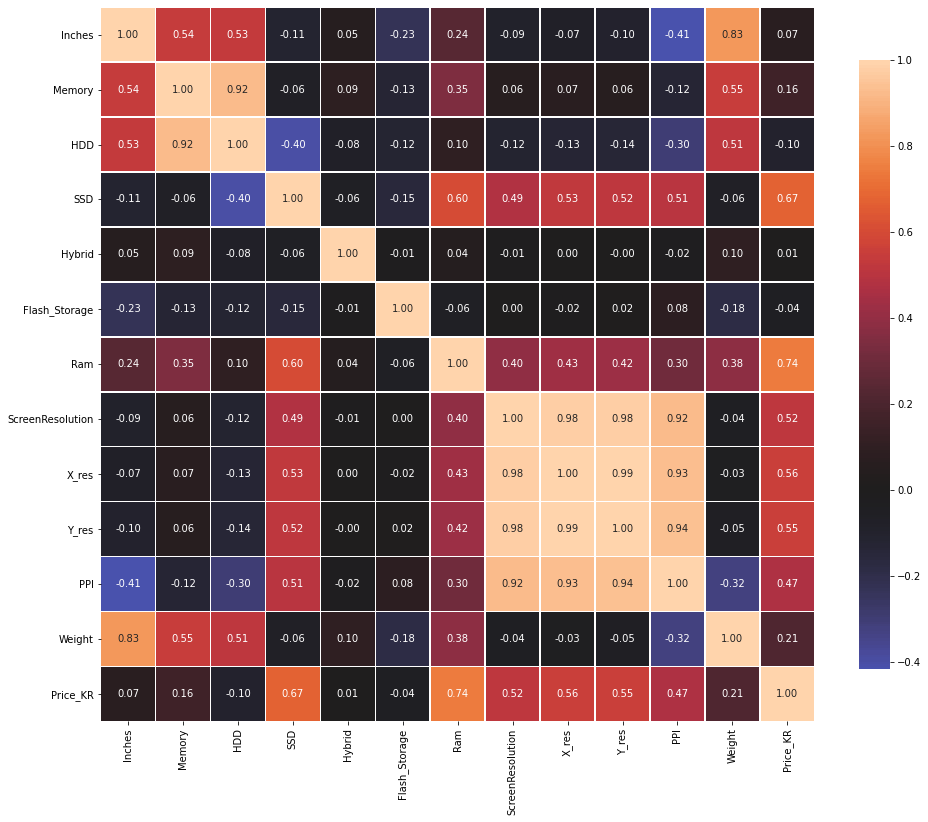

In [ ]:
## 상관계수(회귀)를 통해 관련성 높은 Feature들 찾기
def correlation_heatmap(train):
    correlations = train.corr()
    fig, ax = plt.subplots(figsize=(16,16))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.70})
    plt.show()

correlation_heatmap(df_eda)

# ✓ 'Ram'과 'ScreenResolution'이 target과 유의미한 양의 상관관계를 가지고 있다고 판단했습니다.

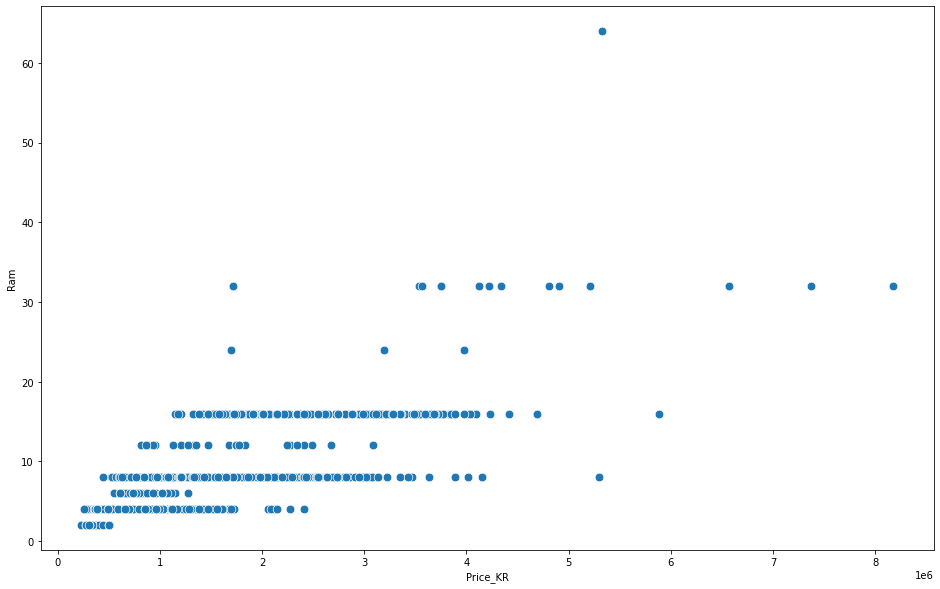

In [ ]:
## 관련성이 높은 Price_KR / Ram 비교
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=df_eda, x="Price_KR", y="Ram", ax=ax, s=75);

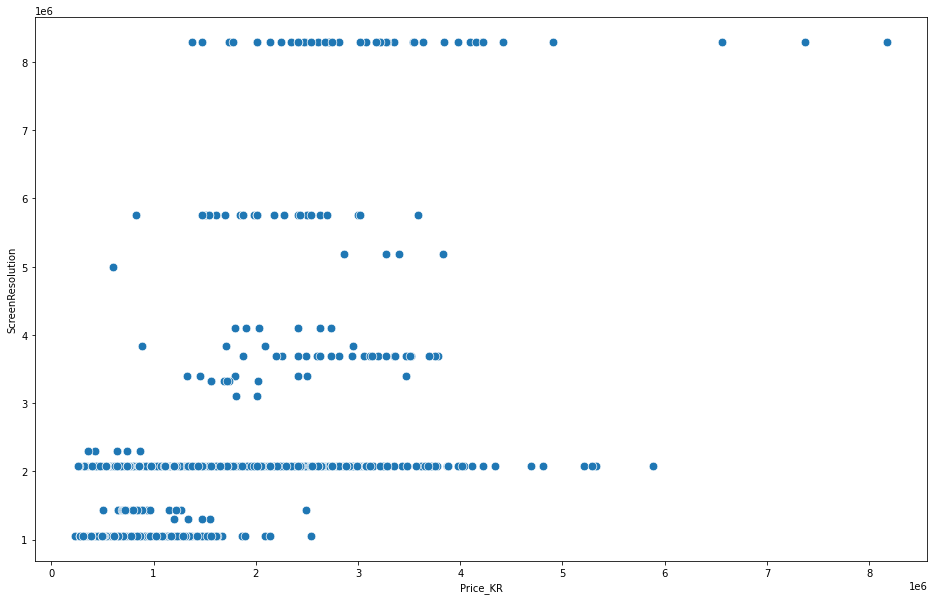

In [ ]:
## 관련성이 높은 Price_KR / ScreenResolution 비교
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=df_eda, x="Price_KR", y="ScreenResolution", ax=ax, s=75);

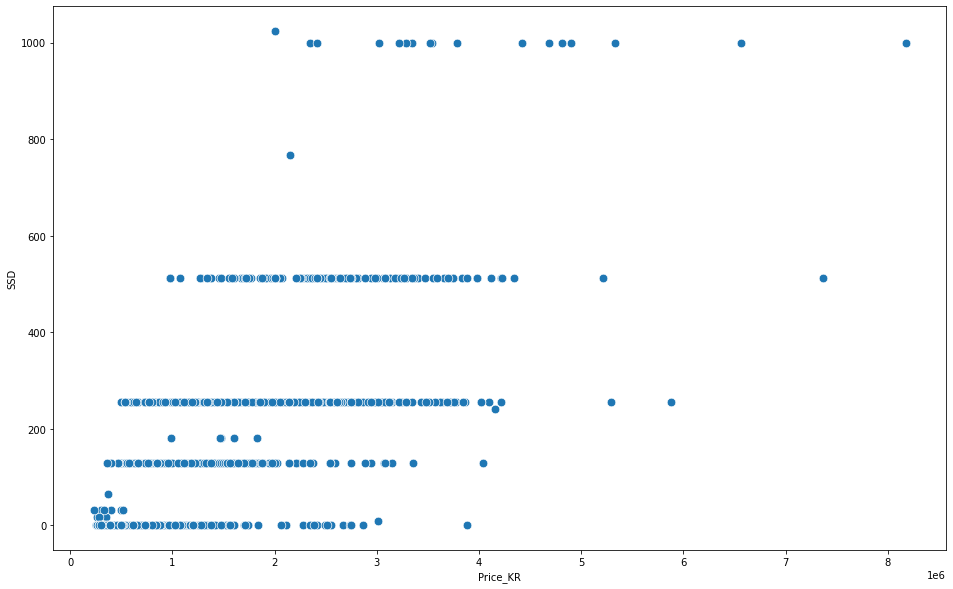

In [ ]:
## 관련성이 높은 Price_KR / SSD 비교
fig_dims = (16, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=df_eda, x="Price_KR", y="SSD", ax=ax, s=75);

In [ ]:
df_eda.dtypes

Product              object
Company              object
TypeName             object
Inches              float64
Cpu                  object
Memory                int64
HDD                   int64
SSD                   int64
Hybrid                int64
Flash_Storage         int64
Gpu                  object
Ram                   int64
OpSys                object
ScreenResolution      int64
X_res                 int64
Y_res                 int64
PPI                 float64
Weight              float64
Price_KR              int64
dtype: object

In [ ]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
## 데이터셋 분리(train/val/test)

target = 'Price_KR'
#y = df_eda[target]              # target
#X = df_eda.drop(target, axis=1) # features
#features = X.columns

train, test = train_test_split(df_eda, train_size=0.8, test_size=0.2, random_state=2)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=2)

train.shape, val.shape, test.shape

#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=2)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=2)

((833, 19), (209, 19), (261, 19))

In [ ]:
features = df_eda.drop(columns = [target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]


In [ ]:
## Baseline Model (Linear Model)

pipe_linear = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    LinearRegression()
)

params = {
    'simpleimputer__strategy' : ['median', 'mean']
}

reg_linear = GridSearchCV(
    pipe_linear,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
    )

reg_linear.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('targetencoder',
                                        TargetEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      min_samples_leaf=1,
                                                      return_df=True,
                                                      smoothing=1.0,
                                                      verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                 

In [ ]:
linear_model = reg_linear.best_estimator_                   # best_estimator_ : 최고 점수를 낸 파라미터를 가진 모형
print('Best parameters : ', reg_linear.best_params_)        # best_params_ : 최고 점수를 낸 파라미터
print('Best score : ', reg_linear.best_score_)              # best_score_ :  최고 점수

Best parameters :  {'simpleimputer__strategy': 'median'}
Best score :  0.7682922894250358


In [ ]:
print('훈련 정확도(linear) : ', linear_model.score(X_train, y_train))
print('검증 정확도(linear) : ', linear_model.score(X_val, y_val))
print('R2_score(linear) : ', linear_model.score(X_test, y_test))

훈련 정확도(linear) :  0.8515687526973929
검증 정확도(linear) :  0.8247119346820426
R2_score(linear) :  0.8096931461880104


In [ ]:
## Ridge Model

pipe_ridge = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    Ridge()
)

params = {
    'simpleimputer__strategy' : ['median', 'mean'],
    'ridge__alpha' : [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

reg_ridge = GridSearchCV(
    pipe_ridge,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
    )

reg_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    8.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('targetencoder',
                                        TargetEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      min_samples_leaf=1,
                                                      return_df=True,
                                                      smoothing=1.0,
                                                      verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                 

In [ ]:
ridge_model = reg_ridge.best_estimator_
print('Best parameters : ', reg_ridge.best_params_)
print('Best score : ', reg_ridge.best_score_)

Best parameters :  {'ridge__alpha': 1, 'simpleimputer__strategy': 'median'}
Best score :  0.7683366672039051


In [ ]:
print('훈련 정확도(ridge) : ', ridge_model.score(X_train, y_train))
print('검증 정확도(ridge) : ', ridge_model.score(X_val, y_val))
print('R2_score(ridge) : ', ridge_model.score(X_test, y_test))

훈련 정확도(ridge) :  0.8515686428723486
검증 정확도(ridge) :  0.8246921967629588
R2_score(ridge) :  0.8096938503064498


In [ ]:
## XGboost Regression

pipe_xgb = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    XGBRegressor(
        random_state = 2,
        n_jobs = -1
    )
)

params = {
    'simpleimputer__strategy' : ['median', 'mean'],
    'xgbregressor__n_estimators' : [100, 200, 300],
    'xgbregressor__learning_rate' : [0.1, 0.2, 0.3],
    'xgbregressor__max_depth' : [5, 7, 10, 15]

}

reg_xgb = GridSearchCV(
    pipe_xgb,
    param_grid=params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
    )

reg_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.2min finished


[06:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('targetencoder',
                                        TargetEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='value',
                                                      min_samples_leaf=1,
                                                      return_df=True,
                                                      smoothing=1.0,
                                                      verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                 

In [ ]:
xgb_model = reg_xgb.best_estimator_
print('Best parameters : ', reg_xgb.best_params_)
print('Best score : ', reg_xgb.best_score_)

Best parameters :  {'simpleimputer__strategy': 'median', 'xgbregressor__learning_rate': 0.2, 'xgbregressor__max_depth': 5, 'xgbregressor__n_estimators': 100}
Best score :  0.8294507177229706


In [ ]:
print('훈련 정확도(XGboost) : ', xgb_model.score(X_train, y_train))
print('검증 정확도(XGboost) : ', xgb_model.score(X_val, y_val))
print('R2_score(XGboost) : ', xgb_model.score(X_test, y_test))

훈련 정확도(XGboost) :  0.9907996153478582
검증 정확도(XGboost) :  0.815299074397885
R2_score(XGboost) :  0.8749417390705736


In [ ]:
xgb = XGBRegressor(
        random_state = 2,
        n_jobs = -1,
        learning_rate = 0.2,
        max_depth = 7,
        n_estimators = 100
)
encoder = xgb_model.named_steps['targetencoder']
imp = xgb_model.named_steps['simpleimputer']

In [ ]:
trans = make_pipeline(
    encoder,
    imp
)

X_train_trans = trans.transform(X_train)
X_test_trans = trans.transform(X_test)

X_train_trans_df = pd.DataFrame(X_train_trans, columns = features)
X_test_trans_df = pd.DataFrame(X_test_trans, columns = features)

In [ ]:
eval_set = [(X_train_trans_df, y_train),
            (X_test_trans_df, y_test)]

xgb.fit(X_train_trans_df, y_train,
        eval_set = eval_set,
        eval_metric = 'rmse',
        early_stopping_rounds = 50)

[06:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.46812e+06	validation_1-rmse:1.35972e+06
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.20641e+06	validation_1-rmse:1.1107e+06
[2]	validation_0-rmse:997466	validation_1-rmse:921648
[3]	validation_0-rmse:829008	validation_1-rmse:765577
[4]	validation_0-rmse:694450	validation_1-rmse:646667
[5]	validation_0-rmse:586488	validation_1-rmse:556089
[6]	validation_0-rmse:499900	validation_1-rmse:483131
[7]	validation_0-rmse:430153	validation_1-rmse:426570
[8]	validation_0-rmse:375606	validation_1-rmse:386156
[9]	validation_0-rmse:330313	validation_1-rmse:355840
[10]	validation_0-rmse:293539	validation_1-rmse:336682
[11]	validation_0-rmse:264136	validation_1-rmse:321982
[12]	validation_0-rmse:239458	validation_1-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# shap 그리기
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_trans_df)

### Draw SHAP plots ###
shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = X_test_trans_df
)